In [1]:
%pylab inline

import numpy as np
import pandas as pd
import xgboost as xgb
import gc


Populating the interactive namespace from numpy and matplotlib


/home/spark/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
xgb.__version__

'0.6'

In [3]:

print('Loading data ...')

train = pd.read_csv('../input/train_2016_v2.csv')
prop = pd.read_csv('../input/properties_2016.csv')
sample = pd.read_csv('../input/sample_submission.csv')

print('Binding to float32')

for c, dtype in zip(prop.columns, prop.dtypes):
	if dtype == np.float64:
		prop[c] = prop[c].astype(np.float32)

print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)


Loading data ...


/home/spark/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Binding to float32
Creating training set ...
((90275, 55), (90275,))


In [4]:

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)


split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)


Building DMatrix...


In [3]:


print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)



Building DMatrix...
Training ...
[0]	train-mae:0.488065	valid-mae:0.48112
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.402221	valid-mae:0.395444
[20]	train-mae:0.33268	valid-mae:0.326099
[30]	train-mae:0.276518	valid-mae:0.270132
[40]	train-mae:0.231316	valid-mae:0.225213
[50]	train-mae:0.195059	valid-mae:0.189317
[60]	train-mae:0.166121	valid-mae:0.16072
[70]	train-mae:0.143116	valid-mae:0.138042
[80]	train-mae:0.124973	valid-mae:0.120214
[90]	train-mae:0.11079	valid-mae:0.106351
[100]	train-mae:0.099822	valid-mae:0.095702
[110]	train-mae:0.091454	valid-mae:0.087592
[120]	train-mae:0.085149	valid-mae:0.08158
[130]	train-mae:0.080457	valid-mae:0.077192
[140]	train-mae:0.077015	valid-mae:0.074063
[150]	train-mae:0.07451	valid-mae:0.071827
[160]	train-mae:0.072688	valid-mae:0.070245
[170]	train-mae:0.071374	valid-mae:0.069128
[180]	train-mae:0.070415	valid-mae:0.068366
[190

In [23]:
clf

In [1]:
1.03207826614/15

0.06880521774266667

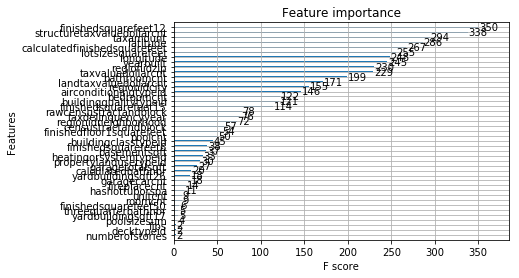

In [24]:
from xgboost import plot_importance
# plot feature importance
plot_importance(clf)
plt.show()

In [5]:


print('Building test set ...')

sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

del prop; gc.collect()

x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

del df_test, sample; gc.collect()

d_test = xgb.DMatrix(x_test)

del x_test; gc.collect()

print('Predicting on test ...')

p_test = clf.predict(d_test)

del d_test; gc.collect()

sub = pd.read_csv('../input/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

print('Writing csv ...')
sub.to_csv('xgb_starter.csv', index=False, float_format='%.4f') # Thanks to @inversion

Building test set ...


/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Predicting on test ...
Writing csv ...
